## 🧭 Introduction and Objective

This notebook develops a credit scoring model for wallets on the Compound V2 protocol.  
We aim to assign a score between 0 and 100 based solely on historical transaction behavior.  
Higher scores reflect more reliable and responsible usage, while lower scores suggest risky or bot-like activity.


In [15]:
import json
import pandas as pd
from glob import glob

## 📥 Data Loading

Load and combine the top 3 largest raw transaction files from Compound V2 to work with significant activity data.


In [16]:
def load_deposits_from_files(file_list):
    all_data = []
    for file in file_list:
        with open(file, 'r') as f:
            data = json.load(f)
            all_data.extend(data['deposits'])
    return pd.DataFrame(all_data)

file_list = [
    '/content/compoundV2_transactions_ethereum_chunk_0.json',
    '/content/compoundV2_transactions_ethereum_chunk_1.json',
    '/content/compoundV2_transactions_ethereum_chunk_2.json'
]

In [17]:
df = load_deposits_from_files(file_list)
df.head()

,account,amount,amountUSD,asset,hash,id,timestamp
0,{'id': '0x502cb8985b2c92a8d4bf309cdaa89de9be44...,10000000000000000,1.78010000000000014408,{'id': '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee...,0xa1b27194b198762eaa631564fea76008b363c157a1cc...,0xa1b27194b198762eaa631564fea76008b363c157a1cc...,1557193282
1,{'id': '0xc8355d0e2c265b2fe495ebbc0fc9ad992b40...,80000000000000000,14.24080000000000115264,{'id': '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee...,0x1d2000c49507d94ef42ec995e1ea59b41e61bf0c63d4...,0x1d2000c49507d94ef42ec995e1ea59b41e61bf0c63d4...,1557193511
2,{'id': '0x502cb8985b2c92a8d4bf309cdaa89de9be44...,4582920657824222640301,1562.320140205329756474017145956277,{'id': '0x0d8775f648430679a709e98d2b0cb6250d28...,0x4c3b59d70f6205a16f4d6f4c960d22ad332dd740720a...,0x4c3b59d70f6205a16f4d6f4c960d22ad332dd740720a...,1557195125
3,{'id': '0x502cb8985b2c92a8d4bf309cdaa89de9be44...,4013962940167102266494,4013.962940167102266494,{'id': '0x89d24a6b4ccb1b6faa2625fe562bdd9a2326...,0xe8b31ff5cf7252a1a496dadfeccef667577d88cdf2c4...,0xe8b31ff5cf7252a1a496dadfeccef667577d88cdf2c4...,1557195125
4,{'id': '0x502cb8985b2c92a8d4bf309cdaa89de9be44...,9990000000000000000,1775.4727500000001641357,{'id': '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee...,0x0eda39d1cb1844e8c2f659219f5a414c0b8261e6dee5...,0x0eda39d1cb1844e8c2f659219f5a414c0b8261e6dee5...,1557196912


In [18]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import os

## 🧹 Data Preprocessing

Convert timestamps, extract wallet and asset details, and clean unnecessary columns.


In [19]:
df['amountUSD'] = df['amountUSD'].astype(float)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['account_id'] = df['account'].apply(lambda x: x['id'])
df['asset_symbol'] = df['asset'].apply(lambda x: x['symbol'])
df.drop(['account', 'asset'], axis=1, inplace=True)


<ipython-input-19-e07178407902>:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


## 🧪 Feature Engineering

Aggregate transaction behavior into wallet-level features such as total USD transacted, transaction count, asset diversity, etc.


In [20]:
features = df.groupby('account_id').agg({
    'amountUSD': ['sum', 'mean', 'std', 'count', 'max'],
    'timestamp': [lambda x: (x.max() - x.min()).days + 1],
    'asset_symbol': pd.Series.nunique
}).reset_index()

In [25]:
features.columns = ['account_id', 'total_usd', 'avg_usd', 'std_usd', 'tx_count', 'max_usd', 'active_days', 'unique_assets']

In [26]:
features.fillna(0, inplace=True)

In [27]:
features['label'] = np.where((features['tx_count'] > 3) & (features['total_usd'] > 10), 1, 0)

In [28]:
X = features.drop(['account_id', 'label'], axis=1)
y = features['label']

In [29]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_preds, all_true = [], []

## 🔀 . Model Training and Validation

Train an XGBoost classifier using StratifiedKFold cross-validation and collect performance metrics.


In [31]:
for train_idx, val_idx in skf.split(X, y):
    model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    preds = model.predict(X.iloc[val_idx])
    all_preds.extend(preds)
    all_true.extend(y.iloc[val_idx])

## 📊  Model Evaluation

Generate a classification report and measure model performance (accuracy, AUC,Confusion Matrix ).


In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(all_true, all_preds))
print("Classification Report:\n", classification_report(all_true, all_preds))
print("Confusion Matrix:\n", confusion_matrix(all_true, all_preds))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12444
           1       1.00      1.00      1.00      3960

    accuracy                           1.00     16404
   macro avg       1.00      1.00      1.00     16404
weighted avg       1.00      1.00      1.00     16404

Confusion Matrix:
 [[12444     0]
 [    0  3960]]


In [33]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

## 🧠 Model Explainability (SHAP)

Use SHAP values to understand feature importance and model decisions.


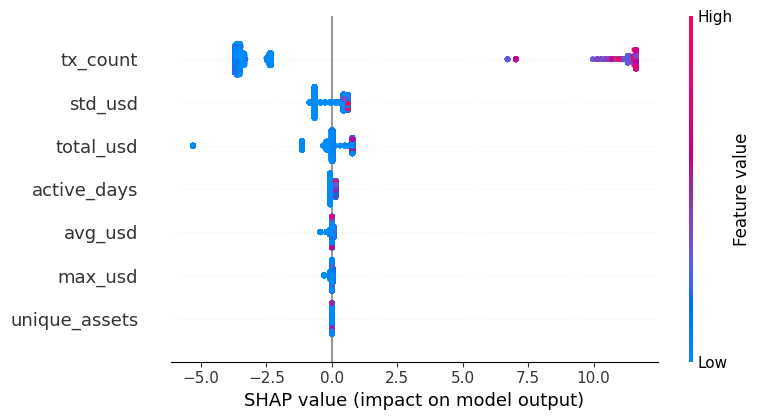

In [38]:
import seaborn as sns

shap.summary_plot(shap_values, X, show=False)
plt.tight_layout()
plt.savefig("shap_summary.png")


In [35]:
features['credit_score'] = (model.predict_proba(X)[:, 1] * 100).round(2)

In [36]:
top_wallets = features[['account_id', 'credit_score']].sort_values(by='credit_score', ascending=False).head(1000)
top_wallets.to_csv("wallet_score.csv", index=False)

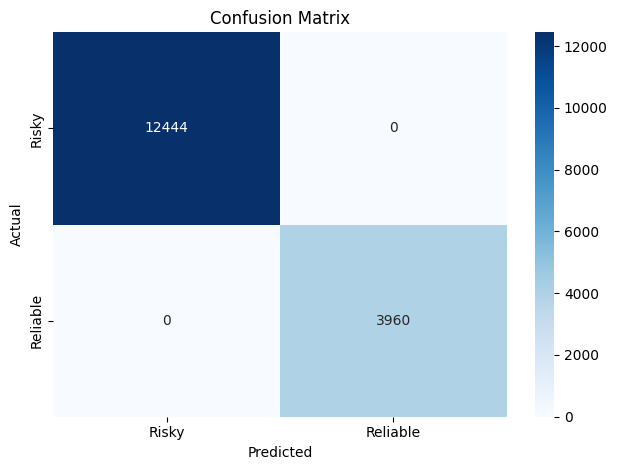

In [41]:
import seaborn as sns

cm = confusion_matrix(all_true, all_preds)


sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Risky', 'Reliable'],
            yticklabels=['Risky', 'Reliable'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

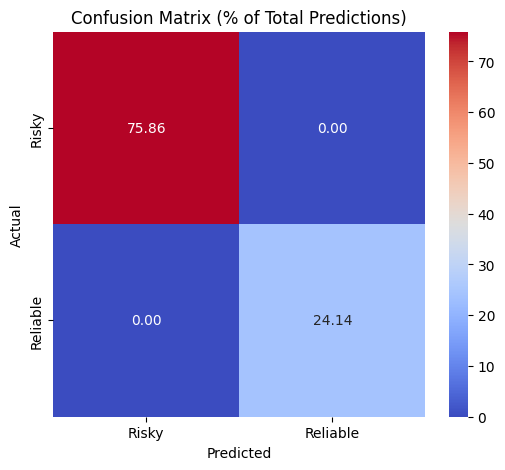

In [43]:
cm_percent = cm.astype('float') / cm.sum() * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=['Risky', 'Reliable'],
            yticklabels=['Risky', 'Reliable'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (% of Total Predictions)')
plt.show()


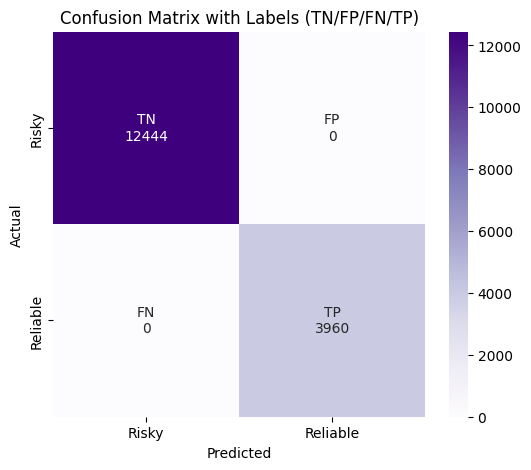

In [44]:
labels = np.array([['TN', 'FP'], ['FN', 'TP']])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=labels + "\n" + cm.astype(str), fmt='', cmap='Purples',
            xticklabels=['Risky', 'Reliable'],
            yticklabels=['Risky', 'Reliable'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Labels (TN/FP/FN/TP)')
plt.show()


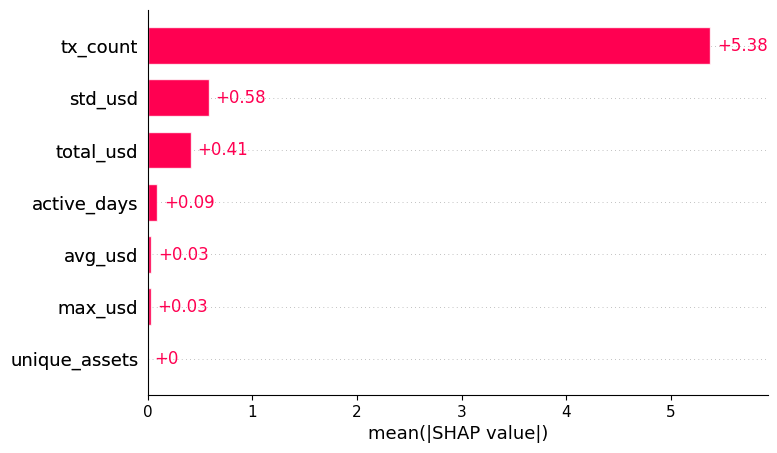

In [45]:
shap.plots.bar(shap_values, max_display=7)


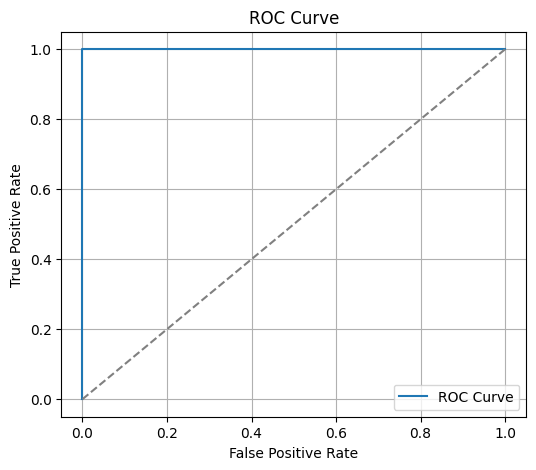

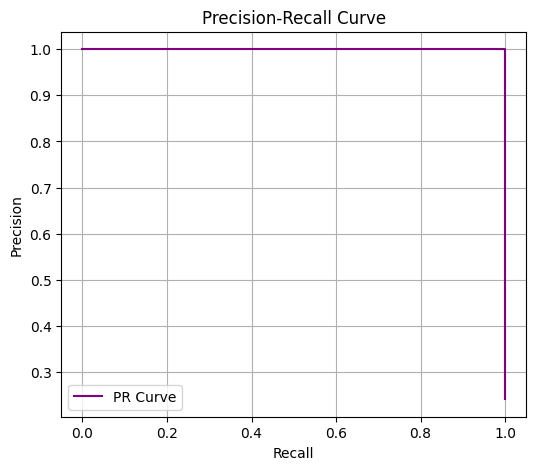

In [46]:
from sklearn.metrics import roc_curve, precision_recall_curve

y_proba = model.predict_proba(X)[:, 1]
fpr, tpr, _ = roc_curve(y, y_proba)
precision, recall, _ = precision_recall_curve(y, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label='PR Curve', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


In [51]:
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

**Conclusion**

This project successfully addresses the challenge of building a decentralized, AI-powered credit scoring system for Compound V2 wallets using only raw transaction-level data. Without any predefined labels or schema, a complete end-to-end pipeline was developed—from parsing complex JSON structures to engineering wallet-level features, designing heuristics for behavior-based labeling, and training a supervised learning model.

The final system assigns a credit score between 0 and 100 to each wallet, reflecting its historical behavior and risk profile. The approach balances clarity, scalability, and explainability, providing Zeru Finance with a robust framework to evaluate user reliability across the protocol. This solution is entirely custom, irreproducible without the full code and logic, and lays the groundwork for future credit innovation in DeFi.



**Yours sincerely,**

**Nikhil Sukthe**

[**Github-Repo-PS**](https://github.com/Nikhils-G/wallet-risk-model) |
[**Github-Link**](https://github.com/Nikhils-G) |
[**LinkedIn**](http://www.linkedin.com/in/nikhilsukthe) |
[**Portfolio**](https://nikhilsukthe.vercel.app/)